# 基于机器学习的时间序列预测

In [1]:
import scipy
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import datetime as dt
import warnings
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import joblib
import math
import pickle
import os
import shutil
from collections import UserDict
from glob import glob
from IPython.display import Image
from datetime import datetime
from typing import List
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

## 可用模型介绍

传统的机器学习算法在时间序列预测中表现不错的有以下几种：

1. 线性回归 (Linear Regression)  
通过建立输入特征和目标变量之间的线性关系来进行预测。适用于简单的时间序列数据，但是对非线性和复杂模式的处理能力有限。
2. 决策树 (Decision Tree)  
决策树通过构建特征的分层决策规则来做预测。它可以处理非线性关系和复杂的模式，不过容易发生过拟合。
3. 随机森林 (Random Forest)  
随机森林是多棵决策树的集合，使用集成学习的思想来提高预测的准确性和稳健性。它可以很好地处理时间序列的复杂性，尤其是带有非线性特征的数据。
4. 支持向量机 (Support Vector Machine, SVM)  
SVM 在时间序列预测中可以用于回归（称为支持向量回归，SVR）。它适合用于复杂的非线性模式，但在高维数据上的计算成本较高。
5. K-近邻算法 (K-Nearest Neighbors, KNN)  
KNN 回归可以用于时间序列预测。它的原理是基于相似的历史数据点来预测未来值，适用于模式重复性强的时间序列。
6. XGBoost/LightGBM  
这些是基于梯度提升决策树 (GBDT) 的集成算法，近年来在时间序列预测中非常受欢迎。它们可以捕捉到非线性关系，并能处理大规模数据集。  

传统机器学习算法在时间序列预测中的应用往往需要将时间序列数据转换为监督学习的形式（例如使用滞后值作为特征），才能更好地进行建模和预测。

## 多步预测方法

在时间序列预测中，多步预测指的是预测多个未来时刻的值。多步预测的方法主要有以下几种：

1. 直接方法（Direct Method）
每个未来时刻单独训练一个模型，即预测第 𝑡+1时刻的一个模型、预测第 t+2 时刻的另一个模型，依此类推。  
优点：每个模型专门针对一个特定的未来时刻进行优化，可能获得较高的预测精度。  
缺点：需要训练多个模型，当预测步数较多时计算成本较高，且模型数量随步数增加。  
2. 递归方法（Iterative Method）
使用一个单步预测的模型反复迭代，先预测第 t+1 时刻的值，然后将其作为输入预测第 t+2 时刻，以此类推。  
优点：只需要训练一个模型，方法简单且直观。  
缺点：预测误差会逐步累积，导致预测精度下降。  
3. 直接递归混合方法（DirRec Method）
结合了直接方法和递归方法，首先预测某个未来时刻，然后将预测结果作为下一步的输入特征。  
这种方法既保持了直接方法的灵活性，又能利用递归方法的连续性，适用于特征较少的场景。  
4. 多输出方法（Multi-Output Method）
训练一个多输出的模型，一次性预测多个未来时刻的值。  
例如，可以使用机器学习模型（如XGBoost/LightGBM）来预测一个包含多个未来时刻值的向量。  
优点：模型只需要训练一次，且能考虑多个未来时刻之间的相关性。  
缺点：对于长时间跨度的预测，模型复杂度较高，且难以保证所有输出的准确性。  
5. 状态空间模型（State Space Models）
基于状态空间的方法（如卡尔曼滤波、粒子滤波）来做多步预测，通过构建状态转移模型迭代预测未来时刻的状态。  
适用于包含噪声和不确定性的时间序列数据。  
6. 组合方法（Ensemble Methods）
将多种方法结合使用。例如，可以使用递归方法得到初步预测，再使用直接方法对其进行调整。  
可以利用不同方法的优点，减少单一方法的缺点。  

# 基于XGBoost的时间序列预测

## 多输入单输出单步预测

### 数据准备

In [97]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)
    
    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col] # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [98]:
data_path = "../outputs/datasets/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00
...,...,...
2014-12-31 19:00:00,"4,012.00",18.00
2014-12-31 20:00:00,"3,856.00",16.67
2014-12-31 21:00:00,"3,671.00",17.00
2014-12-31 22:00:00,"3,499.00",15.33


### 特征构造

In [99]:
# 时间特征构造，包含日期时间特征、滞后特征和窗口特征、滚动窗口统计信息
def generated_features(data: pd.DataFrame, date_type: List[str], seq_len: int,
                       window_type: List[str], freq: str):
    """
    时间特征构造

    参数说明
    ----------
    data : {DataFrame}
        输入数据
    date_type : {List[str]}
        日期特征，包含year,month,day,hour,minute,second,week等
    seq_len : {int}
        seq_len表示最多后移几位
    window_type : {int} 
        滑动窗口特征，包含min, mean, max等
    freq : {str} 
        滞后频率，包含'h','t','s'等

    返回值
    -------
    data : {DataFrame}
        输出数据
    """
    # 滞后特征和窗口特征
    for var in data.columns:
        for t in range(1, seq_len + 1):
            data[var + "_lag" + str(t)] = data[var].shift(t, freq=freq)

        # 滚动窗口统计信息
        shifted = data[var].shift(1)
        window = shifted.rolling(window=seq_len)
        for stats in window_type:
            data[var + "_" + stats] = eval(f"window.{stats}()")

    # 日期时间特征
    for types in date_type:
        if types == 'day':
            data[types] = [data.index[i].day for i in range(len(data))]
        elif types == 'hour':
            data[types] = [data.index[i].hour for i in range(len(data))]
        elif types == 'minute':
            data[types] = [data.index[i].minute for i in range(len(data))]
        elif types == 'second':
            data[types] = [data.index[i].second for i in range(len(data))]
        elif types == 'month':
            data[types] = [data.index[i].month for i in range(len(data))]

    # 删除None数据
    data = data.dropna()

    return data

In [100]:
# 构造参数字典
params1 = {
    "data": ts_data,
    "date_type": ['day', 'hour', 'week'],
    "seq_len": 6,
    "window_type": ["min", "mean", "max"],
    "freq": 'h',
}

#函数传参
data = generated_features(**params1)

### 数据划分

In [101]:
# 包含时间维度的数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    #归一化
    x_scaler = MinMaxScaler() # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list]) 
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    #测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr]

    #验证集
    valid = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
    valid[x_feature_list] = x_scaler.transform(valid)
    xva = valid.values.astype('float32')
    yva = df.copy().iloc[int(df.shape[0]*train_ratio): int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
    yva[y_feature_list] = y_scaler.transform(yva)
    yva = yva.values.astype('float32')
    valid = [xva, yva]

    #测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte]
    else:
        test = [np.array(0), np.array(0)]
    
    return x_scaler, y_scaler, train, valid, test

In [102]:
# 构造参数字典
params2 = {
    "df": data,
    "train_ratio": 0.8,
    "valid_ratio": 0.1,
    "x_feature_list": list(set(data.columns)-set(['temp'])),
    "y_feature_list": ['temp'],
    "scaler_path": '../outputs/scalers/XGBoost'
}

#函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params2)
x_train, y_train = train_data[0], train_data[1]
x_test, y_test = test_data[0], test_data[1]
print("x_train shape: {0} y_train shape: {1}".format(train_data[0].shape, train_data[1].shape))
print("x_valid shape: {0} y_valid shape: {1}".format(valid_data[0].shape, valid_data[1].shape))
print("x_test shape: {0} y_test shape: {1}".format(test_data[0].shape, test_data[1].shape))

x_train shape: (21038, 21) y_train shape: (21038, 1)
x_valid shape: (2630, 21) y_valid shape: (2630, 1)
x_test shape: (2630, 21) y_test shape: (2630, 1)


### 模型训练

In [119]:
def train(train_args, model_args):
    # 参数配置
    model_path = train_args['model_path']
    x_train = train_args['x_train']
    y_train = train_args['y_train']
    
    # 模型训练
    xgb = XGBRegressor(**model_args)
    model = xgb.fit(x_train, y_train)
    
    # 保存模型
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
        
    return model

In [134]:
# 构造参数字典
params3 = {
    "train_args": {
        "model_path": "../outputs/best_models/XGBoost/xgboost.pkl",
        "x_train": x_train,
        "y_train": y_train,
    },
    "model_args": {
        'n_estimators': 100,
        'max_depth': 50, 
        'learning_rate': 0.1,
        'random_state': 0,
    },
}
model = train(**params3)

### 模型测试

In [135]:
def test(model, x_test, y_test):
    prediction = model.predict(x_test)
    # 计算R2，均方差
    r2 = r2_score(y_test, prediction)
    mse = np.sqrt(mean_squared_error(y_test, prediction))
    print("mse: {:.4f}\nr2: {:.4f}".format(mse, r2))
    return 0

In [136]:
res = test(model, x_test, y_test)

mse: 0.0102
r2: 0.9932


### 结果分析

In [137]:
def plot(data, x_test, model, scaler):
    index = 1 # 预测列的索引
    prediction = model.predict(x_test)
    test_plot_y = y_scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1, )
    test_plot_x = data.iloc[-len(test_plot_y):, index].index
    timeseries_y = data.iloc[-len(test_plot_y):, index].values
    timeseries_x = test_plot_x
    # 局部静态图
    def static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y):
        #绘图，原始图，训练图，验证图，测试图
        fig = plt.figure(1, (10, 5))
        ax = fig.add_subplot(1,1,1)
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.title('true-predict-curve ') #图标题
        plt.xticks(rotation = 45) #rotation文字旋转方向
        ax.plot(timeseries_x, timeseries_y, linestyle='-',label = 'true_curve')
        ax.plot(test_plot_x, test_plot_y, linestyle='--',label = 'predict_curve')
        ax.legend(frameon=False) #绘制图例
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.show()
    static_part_timeseries(timeseries_x, timeseries_y, test_plot_x, test_plot_y)
    return 0

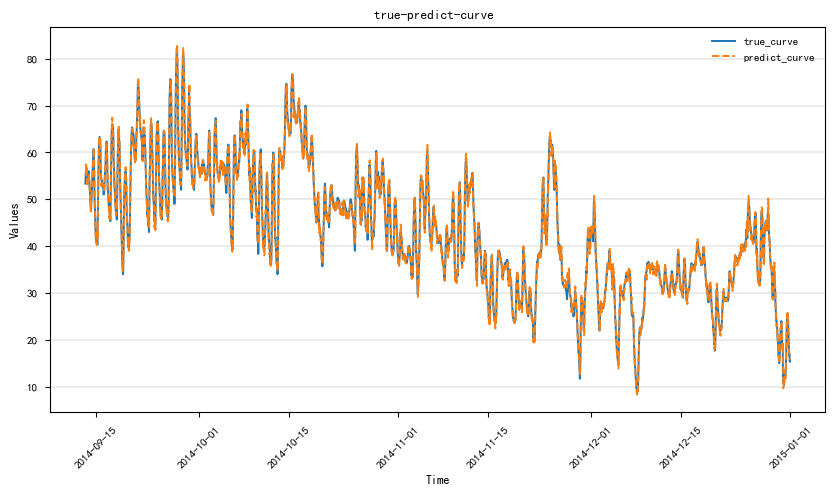

0

In [138]:
plot(data, x_test, model, y_scaler)

### 模型预测

In [139]:
def predict(task_args, feature_args, model_args):
    # 参数配置
    target = task_args['target'] 
    scaler_path = task_args['scaler_path'] 
    model_path = task_args['model_path'] 
    time_col = task_args['time_col'] 
    x_true = feature_args['x_true'] 
    date_type = feature_args['date_type'] 
    seq_len = feature_args['seq_len']
    freq = feature_args['freq']
    window_type = feature_args['window_type'] 

    # 构造数据集
    x_true = loader(data_path=None, data=x_true, time_col=time_col) # 原始数据
    time_columns = x_true.index # 获取时间列

    # 特征构造
    x_true = generated_features(x_true, date_type, seq_len, window_type, freq)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")
    y_scaler = joblib.load(scaler_path + "/y_scaler.pkl")

    # 归一化
    x_feature_list = list(set(x_true.columns)-set(target))
    x_true[x_feature_list] = x_scaler.transform(x_true[x_feature_list])
    xtr = x_true[x_feature_list].values.astype('float32')

    # 加载模型
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # 模型预测
    prediction = model.predict(xtr)

    # 反归一化
    y_pred = y_scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1, 1)

    # 输出为Dataframe
    y = pd.DataFrame(data=None, columns=target, index=time_columns)
    y.iloc[seq_len:, :] = y_pred
    y_pred = y.reset_index().rename(columns={'index': time_col})
        
    return y_pred

In [140]:
data_path = "../outputs/datasets/energy.csv"
ts_data = pd.read_csv(data_path)
ts_data

,time,load,temp
0,2012-01-01 00:00:00,"2,698.00",32.00
1,2012-01-01 01:00:00,"2,558.00",32.67
2,2012-01-01 02:00:00,"2,444.00",30.00
3,2012-01-01 03:00:00,"2,402.00",31.00
4,2012-01-01 04:00:00,"2,403.00",32.00
...,...,...,...
26299,2014-12-31 19:00:00,"4,012.00",18.00
26300,2014-12-31 20:00:00,"3,856.00",16.67
26301,2014-12-31 21:00:00,"3,671.00",17.00
26302,2014-12-31 22:00:00,"3,499.00",15.33


In [141]:
# 构造参数字典
params4 = {
    "task_args":{
        'target': ['temp'],
        'model_path': "../outputs/best_models/XGBoost/xgboost.pkl",
        'scaler_path': '../outputs/scalers/XGBoost',
        'time_col': 'time',
    },
    "feature_args": {
        'x_true': ts_data,
        "date_type": ['day', 'hour', 'week'],
        "seq_len": 6,
        "window_type": ["min", "mean", "max"],
        "freq": 'h',
    },
    "model_args": {
        'n_estimators': 100,
        'max_depth': 50, 
        'learning_rate': 0.01,
        'random_state': 0,
    },
}
y_pred = predict(**params4)

In [142]:
y_pred

,time,temp
0,2012-01-01 00:00:00,NaN
1,2012-01-01 01:00:00,NaN
2,2012-01-01 02:00:00,NaN
3,2012-01-01 03:00:00,NaN
4,2012-01-01 04:00:00,NaN
...,...,...
26299,2014-12-31 19:00:00,18.53
26300,2014-12-31 20:00:00,17.20
26301,2014-12-31 21:00:00,16.97
26302,2014-12-31 22:00:00,16.69


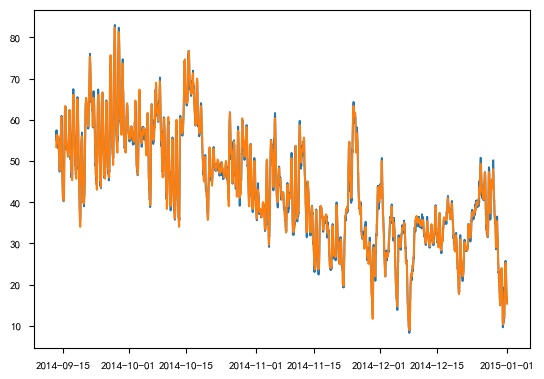

In [143]:
plt.plot(y_pred['time'].values[-2630:], y_pred['temp'].values[-2630:])
plt.plot(y_pred['time'].values[-2630:], ts_data['temp'].values.astype('float32')[-2630:])

## 多输入单输出多步预测